In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import joblib
import seaborn as sns


In [2]:
start = input("Enter start date (YYYY-MM-DD): ")#'2012-01-01'
end = input("Enter end date (YYYY-MM-DD): ")#'2022-12-21'
stock = input("Enter the Stock Symbol")#'TSLA'
data = yf.download(stock, start, end)
data.reset_index(inplace=True)
print(data.head())


Enter start date (YYYY-MM-DD): 2012-01-01
Enter end date (YYYY-MM-DD): 2022-12-21
Enter the Stock SymbolTSLA


[*********************100%%**********************]  1 of 1 completed

        Date      Open      High       Low     Close  Adj Close    Volume
0 2012-01-03  1.929333  1.966667  1.843333  1.872000   1.872000  13921500
1 2012-01-04  1.880667  1.911333  1.833333  1.847333   1.847333   9451500
2 2012-01-05  1.850667  1.862000  1.790000  1.808000   1.808000  15082500
3 2012-01-06  1.813333  1.852667  1.760667  1.794000   1.794000  14794500
4 2012-01-09  1.800000  1.832667  1.741333  1.816667   1.816667  13455000


In [3]:
# Splitting the data into training and testing sets
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scale = scaler.fit_transform(data_train[['Close']])
data_test_scale = scaler.transform(data_test[['Close']])

In [4]:
# Function to create dataset with look-back
def create_dataset(data, look_back=10):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
x_train, y_train = create_dataset(data_train_scale, look_back)
x_test, y_test = create_dataset(data_test_scale, look_back)

# Reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [5]:
# Defining the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
69/69 [==============================] - 6s 11ms/step - loss: 0.0047
Epoch 2/10
69/69 [==============================] - 1s 11ms/step - loss: 6.0377e-04
Epoch 3/10
69/69 [==============================] - 1s 12ms/step - loss: 5.8596e-04
Epoch 4/10
69/69 [==============================] - 1s 12ms/step - loss: 6.7994e-04
Epoch 5/10
69/69 [==============================] - 1s 12ms/step - loss: 5.7185e-04
Epoch 6/10
69/69 [==============================] - 1s 12ms/step - loss: 6.0848e-04
Epoch 7/10
69/69 [==============================] - 1s 12ms/step - loss: 5.3078e-04
Epoch 8/10
69/69 [==============================] - 1s 12ms/step - loss: 5.3805e-04
Epoch 9/10
69/69 [==============================] - 1s 12ms/step - loss: 5.2770e-04
Epoch 10/10
69/69 [==============================] - 1s 12ms/step - loss: 6.6406e-04


17/17 [==============================] - 1s 4ms/step


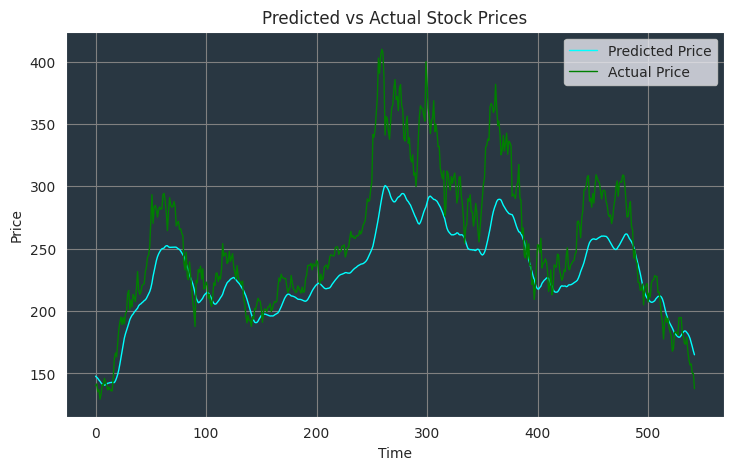

In [6]:
# Making predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
actual_prices = data_test['Close'].values[look_back:]

# Plotting the results
sns.set_style("darkgrid")
plt.figure(figsize=(8.5, 5))
plt.plot(predictions, label='Predicted Price', color='cyan', linewidth=1)
plt.plot(actual_prices, label='Actual Price', color='green', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted vs Actual Stock Prices')
plt.gca().set_facecolor('#293742')
plt.grid(True, color='grey')
plt.legend()
plt.show()


In [7]:

# Saving the model architecture and weights
model_json = model.to_json()
with open('Stock_Predictions_Model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('Stock_Predictions_Model.weights.h5')

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [8]:
# Function to load the model and scaler
def load_model_and_scaler():
    # Import necessary function
    from keras.models import model_from_json

    # Load model architecture
    with open('Stock_Predictions_Model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)

    # Load model weights
    loaded_model.load_weights('Stock_Predictions_Model.weights.h5')

    # Compile the loaded model
    loaded_model.compile(optimizer='adam', loss='mean_squared_error')

    # Load the scaler
    loaded_scaler = joblib.load('scaler.pkl')

    return loaded_model, loaded_scaler

# Example of loading the model and scaler
loaded_model, loaded_scaler = load_model_and_scaler()